# 今回の取り組み

下記の2つについて、`correct_sequence_error`などで補正するときに、**変異候補の塩基配列のみを対象とする**ことで対応できる可能性がある

+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`replace_n`）
+ [ ] 短いリードの扱いをどうするべきか

- 変異候補の塩基配列のみを対象とする
    - 両端が欠失しているようなリードについて、変異候補部位を含まないリードは`uncategorized`といったカテゴリにできる
    - よって**変異候補部位を含むか含まないか**を考えることで、短いリードや両端が欠失しているリードの分類が可能になる？

`extract_mutation_loci`を作った

- `classify`
    - これは今まで通りでOK
    - mutation_lociを考慮することで多少の高速化につながるが、特に大きな意味を持たないので省略
- `detect_sv`
    - これはなくて良い、もしくは最後に移動する
    - consensus配列が50塩基以上の変異を含む場合に、そのアレルはSVとする
- `clustering`
    - mutation_lociのみの塩基を抽出することで、高速化につなげる

よって、`detect_sv`の移動と`clustering`の変更を行う  

**まずは`clustering`の変更が第一優先**

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)
print(os.getcwd())

/mnt/c/Users/akihi/Documents/GitHub/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

## clusteringにmutation_lociを加える

In [4]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report
from src.DAJIN2.core.clustering import clustering

reload(preprocess)
reload(classification)
reload(clustering)
reload(consensus)
reload(report)


##### # * 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "tests/data/knockout/test_barcode25.fq.gz",
    "tests/data/knockout/test_barcode30.fq.gz",
    "tests/data/knockout/design_stx2.fa",
    "test-knockout",
    "mm10",
    True,
    30,
)

print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.check_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.check_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.check_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.check_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing test-knockout...


In [5]:
# ################################################################################
# # Export fasta files as single-FASTA format
# ################################################################################
# # TODO: use yeild, not export
# for identifier, sequence in FASTA_ALLELES.items():
#     contents = "\n".join([">" + identifier, sequence]) + "\n"
#     output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
#     output_fasta.write_text(contents)
# ###############################################################################
# # Mapping with mappy
# ###############################################################################
# for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
#     name_fasta = path_fasta.stem
#     preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
#     preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
#     preprocess.mappy_align.output_sam(
#         TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
#     )
#     preprocess.mappy_align.output_sam(
#         TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
#     )
# ########################################################################
# # MIDSV conversion
# ########################################################################
# for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
#     preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
# for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
#     preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
# ###############################################################################
# # CSSPLITS Error Correction
# ###############################################################################
# preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
# preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
# ###############################################################################
# # Convert any `N` as deletions other than consecutive `N` from both ends
# ###############################################################################
# preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
# preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
# ###############################################################################
# # Cashe inputs (control)
# ###############################################################################
# if not IS_CACHE_CONTROL:
#     control_hash = Path(CONTROL).read_bytes()
#     control_hash = hashlib.sha256(control_hash).hexdigest()
#     PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
#     PATH_CACHE_HASH.write_text(str(control_hash))


In [6]:
MUTATION_LOCI = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

In [7]:
MUTATION_LOCI.keys()

dict_keys(['deletion', 'control', 'inversion'])

In [8]:
########################################################################
# Classify alleles
########################################################################
print("Classify...")

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)


Classify...


In [9]:
classif_sample[0]

{'QNAME': '0013cef2-2bed-49c3-9253-0672c5f77a77',
 'RNAME': 'deletion',
 'CSSPLIT': 'N,N,N,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,

In [10]:
import midsv
allele = "deletion"

In [11]:
mutation_loci = MUTATION_LOCI[allele]

In [19]:
# control
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Sample
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]

In [20]:
cssplits_mutation = []
for cssplits in cssplits_sample:
    cs_mutation = []
    for i, cs in enumerate(cssplits):
        if i in mutation_loci:
            cs_mutation.append(cs)
    cssplits_mutation.append(cs_mutation)

In [24]:
print(len(cssplits_sample[0]))
print(len(mutation_loci))
print(len(cssplits_mutation[0]))

3582
3071
3071


In [27]:
def extract_cssplits_in_mutation(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i, cs in enumerate(cssplits):
            if i in mutation_loci:
                cs_mutation.append(cs)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation

['=G', '=A', '=A', '=G', '=A', '=C', '=A', '=T', '=A', '=T']

### 比較
- `extract_cssplits_in_mutation`を入れる前後でアレルの分類がうまく行っているか、速度は向上しているのかを調べる

#### `extract_cssplits_in_mutation` 導入前

In [12]:
from __future__ import annotations
from itertools import groupby
from collections import defaultdict
from pathlib import Path
import midsv

from src.DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci
from src.DAJIN2.core.clustering.preprocess import replace_both_ends_n, compress_insertion
from src.DAJIN2.core.clustering.make_score import make_score
from src.DAJIN2.core.clustering.annotate_score import annotate_score
from src.DAJIN2.core.clustering.reorder_labels import reorder_labels
from src.DAJIN2.core.clustering.return_labels import return_labels


def extract_cssplits_in_mutation(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i, cs in enumerate(cssplits):
            if i in mutation_loci:
                cs_mutation.append(cs)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


def add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES: dict, MUTATION_LOCI, THREADS: int = 1) -> list[dict[str]]:
    paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
    cssplits_control_by_alleles = defaultdict(list)
    for path_midsv in paths_midsv:
        midsv_control = midsv.read_jsonl(path_midsv)
        allele = path_midsv.stem.split("_")[-1]
        cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        cssplits_control_by_alleles[allele] = cssplits
    knockin_alleles = extract_knockin_loci(TEMPDIR)
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: set = MUTATION_LOCI[allele]
        cssplits_control = cssplits_control_by_alleles[allele]
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
        # cssplits_control = extract_cssplits_in_mutation(cssplits_control, mutation_loci)
        # cssplits_sample = extract_cssplits_in_mutation(cssplits_sample, nutation_loci)
        cssplits_control = replace_both_ends_n(cssplits_control)
        cssplits_sample = replace_both_ends_n(cssplits_sample)
        cssplits_control = compress_insertion(cssplits_control)
        cssplits_sample = compress_insertion(cssplits_sample)
        mutation_score = make_score(cssplits_control, cssplits_sample, knockin_alleles[allele])
        scores_control = annotate_score(cssplits_control, mutation_score)
        scores_sample = annotate_score(cssplits_sample, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


In [27]:
knockin_alleles = extract_knockin_loci(TEMPDIR)
allele = "deletion"
# control
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Sample
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]

In [28]:
%%time
cssplits_control = replace_both_ends_n(cssplits_control)
cssplits_sample = replace_both_ends_n(cssplits_sample)
cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)
mutation_score = make_score(cssplits_control, cssplits_sample, knockin_alleles[allele])
scores_control = annotate_score(cssplits_control, mutation_score)
scores_sample = annotate_score(cssplits_sample, mutation_score)
labels = return_labels(scores_sample, scores_control)


CPU times: user 39.9 s, sys: 9.3 s, total: 49.2 s
Wall time: 32.7 s


In [29]:
from collections import Counter
Counter(labels)

Counter({1: 492, 2: 499, 3: 501, 4: 8})

#### `extract_cssplits_in_mutation` 導入後

In [30]:
knockin_alleles = extract_knockin_loci(TEMPDIR)
allele = "deletion"
# control
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Sample
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]

In [31]:
%%time
cssplits_control = replace_both_ends_n(cssplits_control)
cssplits_sample = replace_both_ends_n(cssplits_sample)
cssplits_control = extract_cssplits_in_mutation(cssplits_control, mutation_loci)
cssplits_sample = extract_cssplits_in_mutation(cssplits_sample, mutation_loci)
cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)
mutation_score = make_score(cssplits_control, cssplits_sample, knockin_alleles[allele])
scores_control = annotate_score(cssplits_control, mutation_score)
scores_sample = annotate_score(cssplits_sample, mutation_score)
labels = return_labels(scores_sample, scores_control)

CPU times: user 36 s, sys: 14.6 s, total: 50.7 s
Wall time: 27.4 s


In [32]:
from collections import Counter
Counter(labels)

Counter({1: 492, 2: 500, 3: 500, 4: 8})

- 速度の向上が認められた
- クラスタリングの精度は変わらない

最後に、一括で処理してエラーがないか確認する

In [4]:
%%bash
time python misc/quickstart.py

processing test-stx2-deletion...
Classify...
Clustering...
Consensus call...



real	4m4.090s
user	3m32.930s
sys	1m27.942s


ほぼ問題なく実行できました

- アレル4：Nanoporeがうまく読み込むことができなかったリードであり、対処すべき
- アレル5：アレル3（小規模欠失アレル）と同じに見える。対処すべき

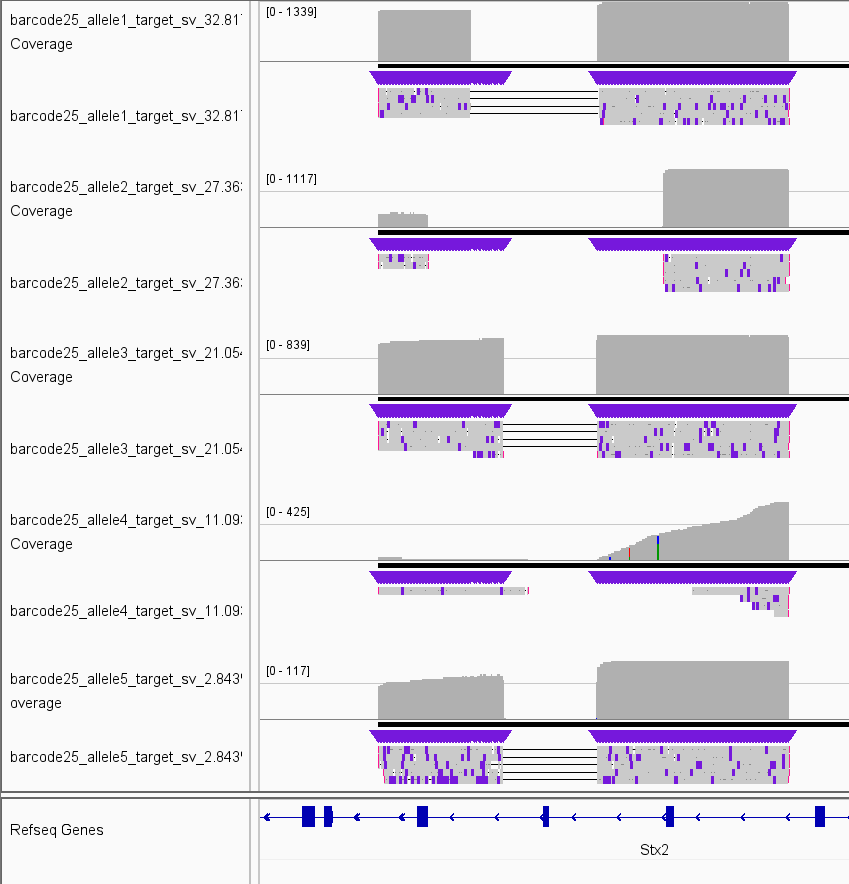

# まとめ


- `MUTATION_LOCI`を`clustering`に組み込みました
    - 速度の向上が期待できる（はず）です

# 次に取り組むこと

### Lists

+ [ ] 短いリードの扱いをどうするべきか
+ [ ] `SV`の判定をconsensus callのあとにする
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`clustering.replace_both_ends_n`）
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする